<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import jax

In [100]:
import jax
jax.config.update("jax_enable_x64", True)

In [101]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc, time_stepping, shard_utils
from jax_ib.base import grids, interpolation, fast_diagonalization, boundaries, pressure as prs, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax.tree_util import register_pytree_node_class, register_dataclass, register_pytree_node
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax.experimental.pjit import pjit
from jax_ib.base import array_utils
import jax
from jax.sharding import NamedSharding
from jax.experimental.custom_partitioning import custom_partitioning
from jax.experimental.pjit import pjit
from jax.sharding import PartitionSpec as P
from jax.sharding import Mesh
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
from jax_ib.base import xfft, utils
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
import numpy as np
import jax_ib.base.fft as fft
import scipy as sp
from scipy import linalg
from jax_ib.base import fast_diagonalization as fdiag

In [6]:
N = 128
M = 8
α, β = 1,1
As = [[None for _ in range(M)] for _ in range(M)]
subA = np.exp(-2*np.pi*1j*np.outer(np.arange(N//M), np.arange(N//M))/N)
exp =  np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
cols = [ np.exp(-2*np.pi*1j/N*j*(N//M) * np.arange(N//M)) for j in range(M)]
rows = [np.exp(-2*np.pi*1j/N*i*(N//M) * np.arange(N//M)) for i in range(M)]
x = np.random.rand(N).astype(np.complex64)
result = []
for i in range(M):
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        As[i][j] = cols[j][:,None]*subA * rows[i][None,:] * phase
for i in range(M):
    temp = np.zeros(N//M, dtype=complex)
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        temp += cols[j]*np.fft.fft(rows[i] *x[j*(N//M):(j+1)*(N//M)], N)[:(N//M)]* phase
    result.append(temp)
    
A = np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
y1 = np.fft.fft(x)
y2 = np.concatenate(result)
A2 = np.concatenate([np.concatenate(As[m], axis=1) for m in range(M)], axis=0)

In [102]:
mesh = jax.make_mesh(axis_shapes = (2,2), axis_names = ('i','j'))
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=1e-4        # time step 

num_boundaries = 4 # in two dimensions there are 4 boundaries
K = 9
L = 15.0
domain = ((0.0,L),(0.0,L))
size=(2**K,2**K)
dtype = jnp.float64
grid = grids.Grid(size, domain=domain, device_mesh = mesh, periods = (L,L), dtype=dtype)

In [103]:
dist_initialize = shard_map(shard_utils.dist_initialize, mesh=mesh, in_specs = (P('i','j'), None), out_specs=(P('i','j'), (P('i','j'),  P('i','j'))))


In [104]:
global_pressure, global_velocities = dist_initialize(np.arange(4).reshape(2,2), grid)


In [115]:
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

velocities = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.zeros_like(x, dtype=dtype), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

pressure = grids.GridVariable(
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x).astype(dtype), offset = grid.cell_center),  boundaries.get_pressure_bc_from_velocity(velocities) 
        ) 

all_variables = pc.All_Variables(velocities,pressure,[0],0,[0], 0.0)

In [105]:
def ellipse(geometry_params, ntheta=200):
    A = geometry_params[0]
    B = geometry_params[1]
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position + jnp.array([amplitude/2 * jnp.cos(2*jnp.pi*frequency*t), 0.0]) - jnp.array([amplitude/2, 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp

In [106]:
particle_geometry_param = jnp.array([[0.5,1.0]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])


In [111]:
eigvals = tuple([np.fft.fft(array_utils.laplacian_column(size, step)) for size, step in zip(grid.shape, grid.step)]) 
def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)    
    
explicit_update = equations.navier_stokes_explicit_terms(
    density=density, viscosity=viscosity, dt=dt,convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
surface_velocity = lambda f,x,y: convolution_functions.mesh_convolve(f,x,y,convolution_functions.gaussian, axis_names=['i','j'])


evolve = jax.jit(shard_map(time_stepping.evolve_navier_stokes_sharded, mesh=mesh, in_specs=(P('i','j'),(P('i','j'), P('i','j')),(P('i'), P('j')),P(),P(),None,None,None, None,None), 
         out_specs=(P('i','j'), (P('i','j'),  P('i','j')))),static_argnums = (4, 5,6,7,8,9))


In [112]:
p, v = global_pressure, global_velocities

In [109]:
ref_time = 0.0
inner_steps = 2000

In [89]:
p, v = evolve(p, v,eigvals,ref_time, dt, 1, inner_steps, ellipse_position, explicit_update, surface_velocity)

In [90]:
p.data

Array([[1.00000395, 1.00000393, 1.0000039 , ..., 1.00000403, 1.00000401,
        1.00000398],
       [1.00000397, 1.00000394, 1.00000391, ..., 1.00000404, 1.00000402,
        1.00000399],
       [1.00000398, 1.00000395, 1.00000393, ..., 1.00000405, 1.00000403,
        1.000004  ],
       ...,
       [1.00000392, 1.0000039 , 1.00000387, ..., 1.000004  , 1.00000397,
        1.00000395],
       [1.00000393, 1.00000391, 1.00000388, ..., 1.00000401, 1.00000398,
        1.00000396],
       [1.00000394, 1.00000392, 1.00000389, ..., 1.00000402, 1.000004  ,
        1.00000397]], dtype=float64)

In [113]:
uxs, uys = [np.array(global_velocities[0].data)], [np.array(global_velocities[1].data)]
ref_time = 0.0
inner_steps = 2000
outer_steps = 10
for step in range(outer_steps):
    print(step)
    p, v = evolve(p, v,eigvals,ref_time, dt, 1, inner_steps, ellipse_position, explicit_update, surface_velocity)
    ref_time += inner_steps * dt
    uxs.append(v[0].data)
    uys.append(v[1].data)
p.data.block_until_ready()

0
1
2
3
4
5
6
7
8
9


Array([[1.01898769, 1.01889573, 1.01880504, ..., 1.01927105, 1.01917536,
        1.0190809 ],
       [1.01889676, 1.018805  , 1.01871449, ..., 1.01917945, 1.019084  ,
        1.01898976],
       [1.01880456, 1.01871299, 1.01862265, ..., 1.0190866 , 1.01899138,
        1.01889736],
       ...,
       [1.01925265, 1.01916004, 1.01906874, ..., 1.01953824, 1.01944177,
        1.01934657],
       [1.01916565, 1.01907326, 1.01898218, ..., 1.01945047, 1.01935426,
        1.01925932],
       [1.01907732, 1.01898516, 1.01889427, ..., 1.0193614 , 1.01926545,
        1.01917076]], dtype=float64)

In [94]:
uxs[-1]

Array([[-0.04090385, -0.04090577, -0.04090903, ..., -0.04090608,
        -0.04090401, -0.04090326],
       [-0.04085002, -0.0408514 , -0.04085412, ..., -0.04085386,
        -0.04085126, -0.04084998],
       [-0.04079487, -0.0407957 , -0.04079787, ..., -0.04080032,
        -0.04079718, -0.04079536],
       ...,
       [-0.04105728, -0.04106079, -0.04106565, ..., -0.04105481,
        -0.0410543 , -0.04105512],
       [-0.04100748, -0.04101046, -0.0410148 , ..., -0.04100656,
        -0.04100553, -0.04100584],
       [-0.04095633, -0.04095879, -0.04096259, ..., -0.04095698,
        -0.04095544, -0.04095522]], dtype=float64)

In [118]:
def internal_post_processing(all_variables,dt):
    return all_variables

surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)

IBM_forcing = lambda velocities,t,dt: IBM_Force.immersed_boundary_force(velocities,
                                                                        [ellipse_position],
                                                                        convolution_functions.gaussian,
                                                                        surf_fn,
                                                                        t,
                                                                        dt)
inner_steps = 2000
outer_steps = 10

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #compute the forcing term to update the particle
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))


In [120]:
actual = final_result

In [123]:
[np.linalg.norm(actual.velocity[n].data - v[n].data) for n in range(2)], np.linalg.norm(actual.pressure.data - p.data)

([np.float64(8.034331344634858e-11), np.float64(5.226870792189392e-11)],
 np.float64(3.734963211620743e-11))

In [30]:
v = tuple([np.array(_.data) for _ in v])

In [34]:
np.max(v[1].data), np.max(actual.velocity[1].data)

(Array(0.73457361, dtype=float64), Array(0.73457361, dtype=float64))

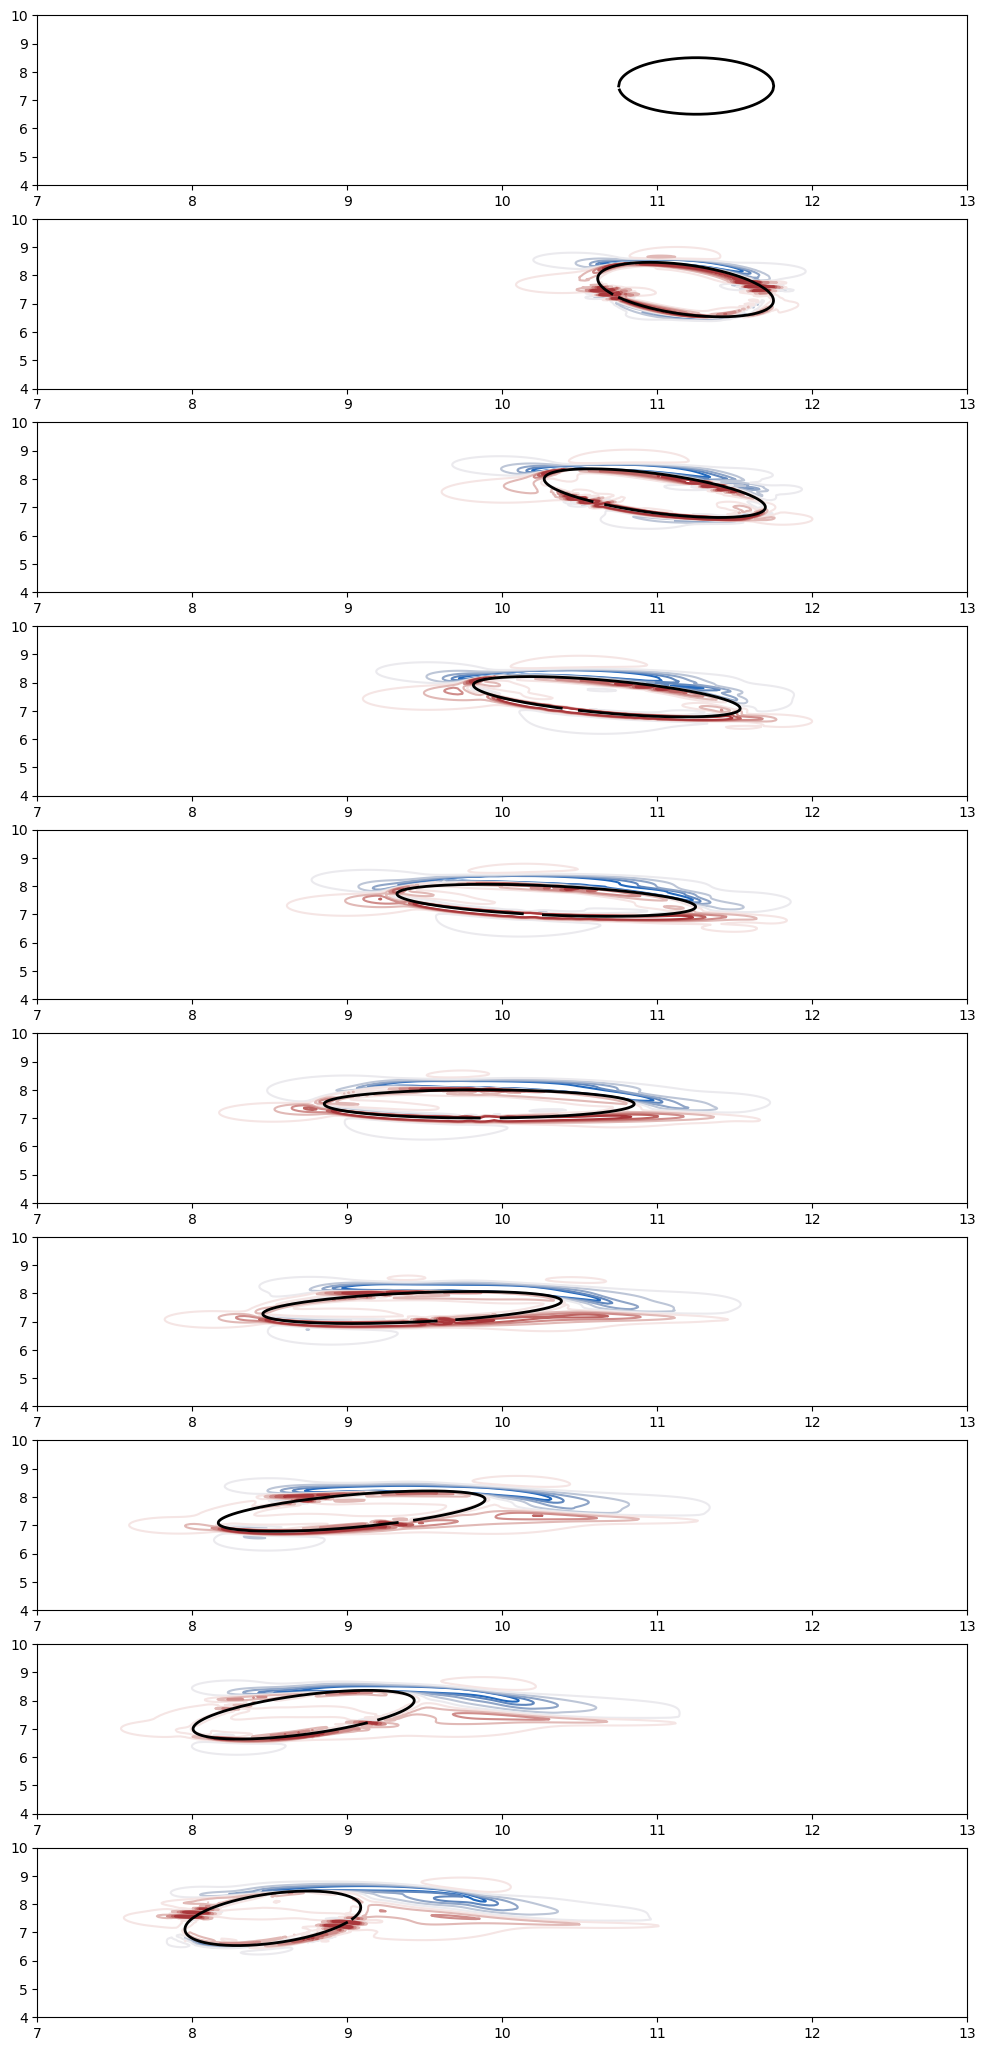

In [124]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid, 0), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid, 0), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps)

idx = 2
counter=0
for idx in range(outer_steps):
    current_t = trajectory.time[idx]
    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1

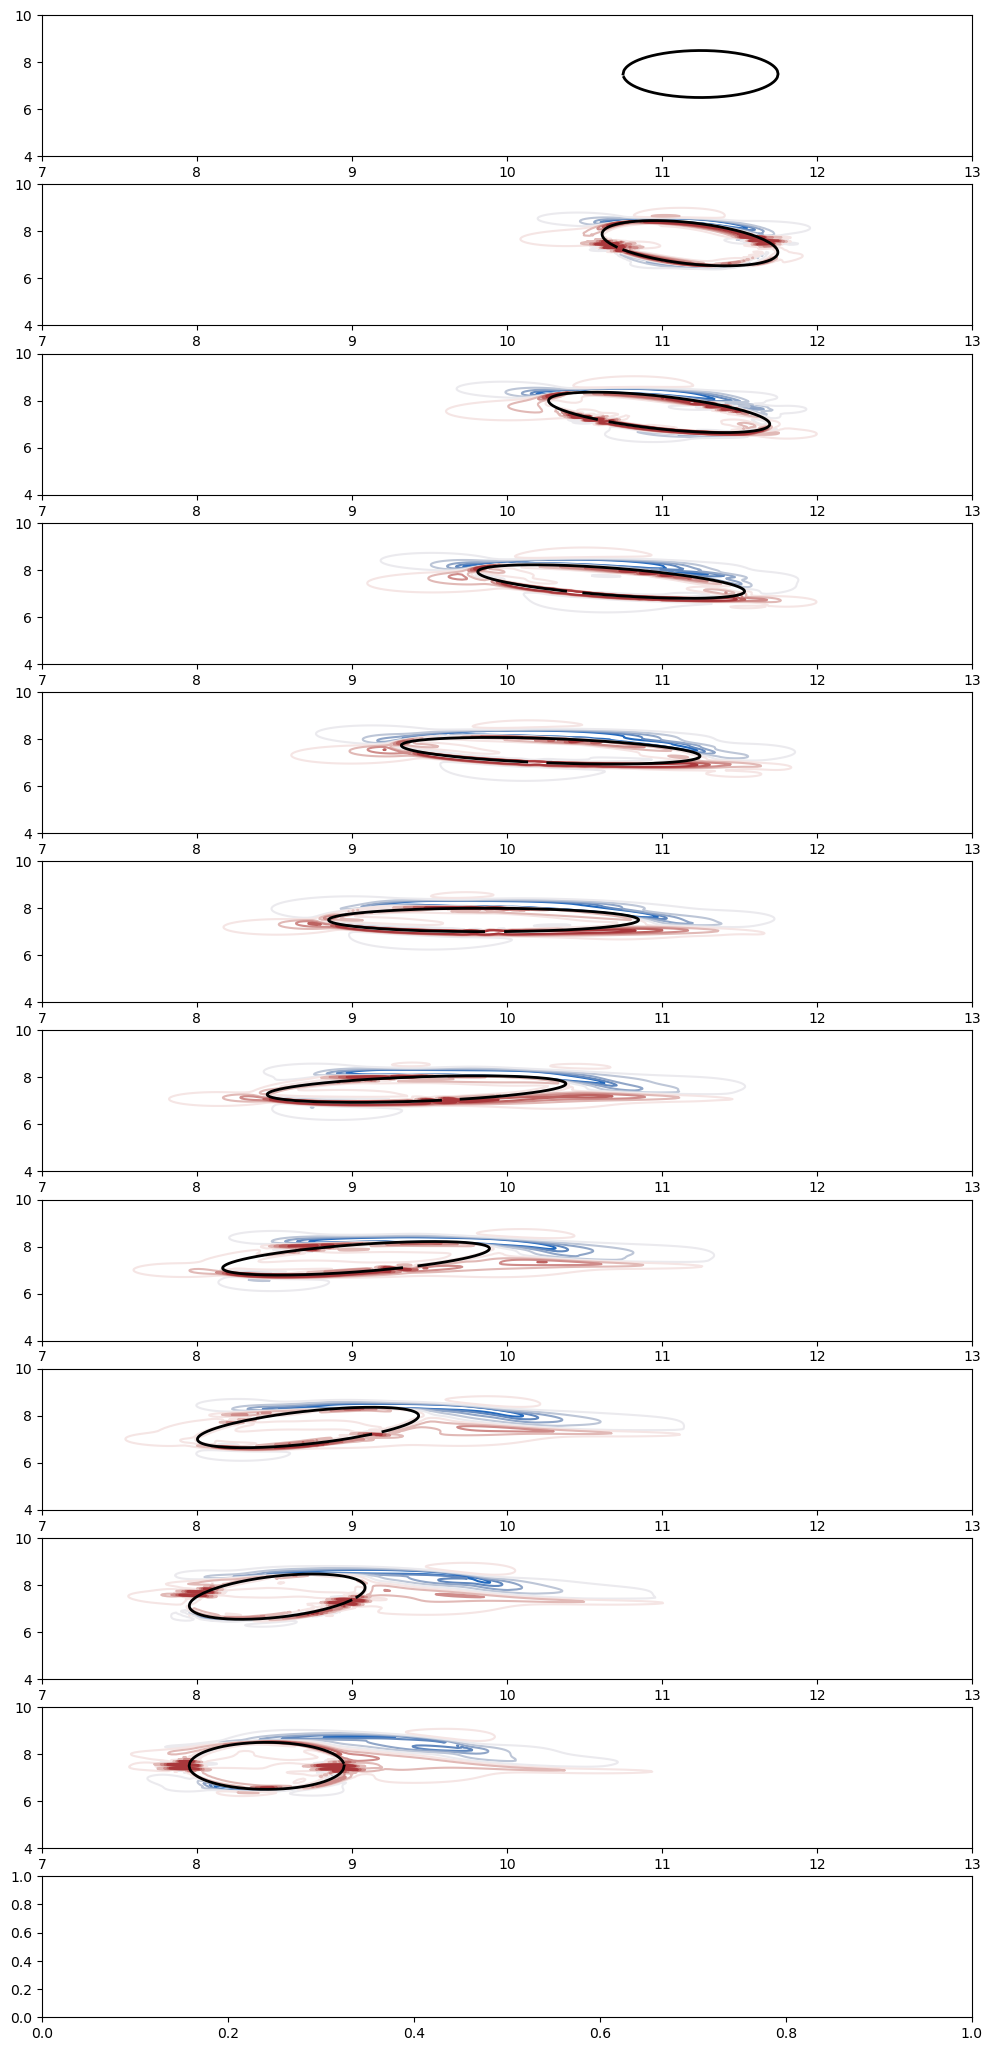

In [125]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity_2(ux, offsetx, uy, offsety, grid, idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = (grids.GridVariable(grids.GridArray(ux[idx], offsetx, grid, 0), vel_bc[0]),
                grids.GridVariable(grids.GridArray(uy[idx], offsety, grid, 0), vel_bc[1]))
    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data


osteps = len(uxs)
fig,ax = plt.subplots(figsize=(12,26),nrows=osteps + 1)
counter=0
offsetx, offsety = global_velocities[0].offset, global_velocities[1].offset
for idx in range(0,osteps):
    current_t = dt * idx*inner_steps
    ax[counter].contour(X,Y,calc_vorticity_2(uxs, offsetx, uys, offsety, grid, idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(current_t)
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])

    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1